In [53]:
from lmfit import Model, Parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

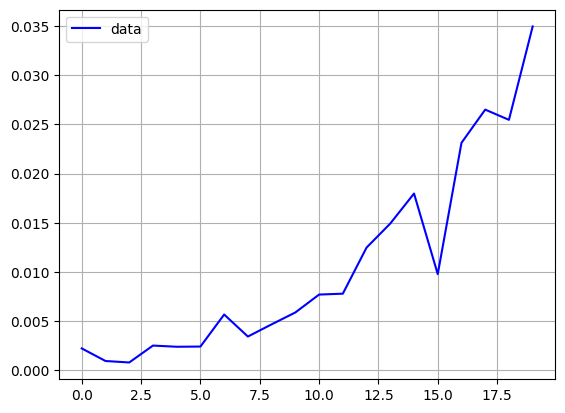

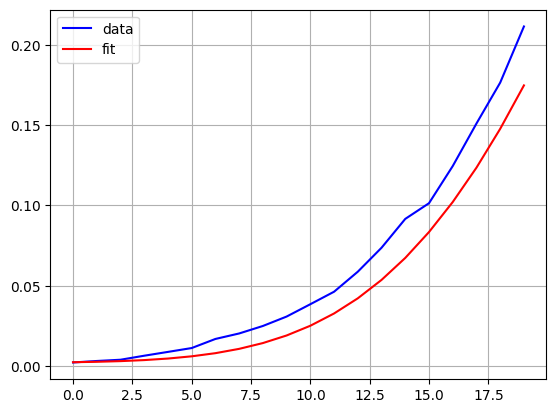

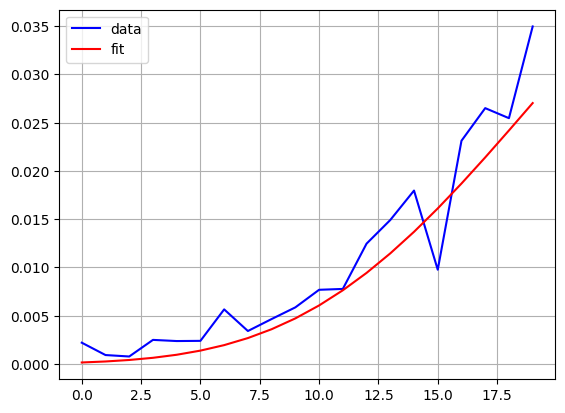

0.17478737147039158
0.21148999999999998
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
K0     2.195     -inf      inf     None    False     None     None
b0     8.985     -inf      inf     None    False     None     None
c0   0.06477     -inf      inf     None    False     None     None
d0   0.00221     -inf      inf     None    False     None     None
n          1     -inf      inf     None    False     None     None
--------------------------
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
K0     2.195     -inf      inf     None    False     None     None
b0     8.985     -inf      inf     None    False     None     None
c0   0.06477     -inf      inf     None    False     None     None
d0   0.00221     -inf      inf     None    False     None     None
n          1     -inf      inf     None    False     None     None
[[Model]]
    Model(cum_gompertz_n)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 0
    # 

In [58]:
t0=0
T=20
t = np.arange(t0,T)
dt=t[1]-t[0]
national_data=pd.read_csv('..\data\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv')
new_pos=national_data['nuovi_positivi'].values[t0:T]
max=100000
new_pos=new_pos/max

cum_pos=np.cumsum(new_pos)
d0=cum_pos[0]
n_curves = 1

plt.figure()
plt.plot(t, new_pos, 'b-', label='data')
plt.legend()
plt.grid(True)
plt.show()

####functions
def make_param_0(n = 1):
    params = Parameters()
    params.add("n", n, vary = False)
    n_pre = dict0['n']

    for i in range(n_pre):
        params.add(f"K{i}", dict0[f'K{i}'], vary = False) #min=0.9*dict0[f'K{i}'], max=1.1*dict0[f'K{i}'])
        params.add(f"b{i}", dict0[f'b{i}'], vary = False) #min=0.9*dict0[f'b{i}'], max=1.1*dict0[f'b{i}'])
        params.add(f"c{i}", dict0[f'c{i}'], vary = False) #min=0.9*dict0[f'c{i}'], max=1.1*dict0[f'c{i}'])
        params.add(f"d{i}", 0, vary = False)

    for i in np.arange(n_pre,n):
        params.add(f"K{i}", 10, min=0)
        params.add(f"b{i}", 100, min=dict0[f'b{i-1}'])
        params.add(f"c{i}", 0.01, min=0)
        params.add(f"d{i}", 0, vary = False)

    params['d0'].value = d0

    return params

# Define the Gompertz bell curve function
def gompertz(t, K, r, c):
    return K*r*c*np.exp(-c*(t))*np.exp(-r*np.exp(-c*(t)))

# Fit on the S curve
def cum_gompertz(t, K, b, c, d):
    return np.cumsum(gompertz(t, K, b, c)) + d # + (cum_pos[-1]-d-np.cumsum(richardson(t, K, r, tm, nu))[-1])/(t[-1]-t[0])*(t-t[0])


def cum_gompertz_n(t, n, **kwargs):
    sum = np.zeros(np.shape(t)[0])
    for i in range(n):
        sum += cum_gompertz(t, K = kwargs[f"K{i}"], 
                             b = kwargs[f"b{i}"], c = kwargs[f"c{i}"], 
                             d = kwargs[f"d{i}"])
    return sum #+ (cum_pos[-1]-sum[-1])/(t[-1]-t[0])*(t-t[0])

################



# create model
fmodel = Model(cum_gompertz_n)
# create parameters -- these are named from the function arguments --
# giving initial values
params = make_param_0(n = n_curves)

# fit the model
result = fmodel.fit(cum_pos, params, t=t, max_nfev=100000, weights=1/new_pos)
sigma = result.eval_uncertainty()

plt.figure()
plt.plot(t, cum_pos, 'b-', label='data')
plt.plot(t, result.best_fit, 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, new_pos, 'b-', label='data')
for i in range(n_curves):
    plt.plot(t, gompertz(t, result.params[f'K{i}'].value, result.params[f'b{i}'].value, result.params[f'c{i}'].value), 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

print(result.best_fit[-1])
print(cum_pos[-1])

params.pretty_print()
print('--------------------------')
result.params.pretty_print()
print(result.fit_report())

In [ ]:
update_dict=False
if update_dict==True:
    def make_dict_params(n = 1):
        D_param0 = {}
        for i in range(n):
            D_param0 |= {f"K{i}" : result.params[f'K{i}'].value,  
                f"b{i}" : result.params[f'b{i}'].value,
                f"c{i}" : result.params[f'c{i}'].value,
                f"d{i}" : result.params[f'd{i}'].value,
                f"n" : result.params['n'].value}

        return D_param0

    dict0 = make_dict_params(1)
    print(dict0)
